<a href="https://colab.research.google.com/github/MucaCirone/Master_Thesis/blob/main/BTC_rSig.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook shows the use of Randomized Signatures on real-world datasets.

I am going to use the BitCoin dataset used by Cris Salvi, my future PhD supervisor, in his paper "*The Signature Kernel is the solution of a Goursat PDE*" (https://arxiv.org/abs/2006.14794). 

This choiche was made in order to compare rSigs with the state-of-the-art SigKer algorithms on datasets where SigKer is already known to perform very well. 

We are going to analyze historycal closing price BTC data trying to predict the mean of the price over the next 2 days given the past 36.

# Import Libraries

In [1]:
!pip install git+https://github.com/crispitagorico/sigkernel.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/crispitagorico/sigkernel.git to /tmp/pip-req-build-pisbyod_
  Running command git clone -q https://github.com/crispitagorico/sigkernel.git /tmp/pip-req-build-pisbyod_
     |████████████████████████████████| 793 kB 9.2 MB/s 
  Created wheel for sigkernel: filename=sigkernel-0.0.1-cp37-cp37m-linux_x86_64.whl size=275385 sha256=f66d9cacd4c52d8ec0606109c5d88548bc72facb7e82c2fbdd267de032fca1fb
  Stored in directory: /tmp/pip-ephem-wheel-cache-v347vgoa/wheels/64/28/de/9c6a353b52fc67cb4988ebd7a5b762e476edaa0af110d23493
Successfully built sigkernel


In [2]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from scipy import linalg
import random
from tqdm import tqdm
import pandas as pd
import torch
import sigkernel
import time

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
          'figure.figsize': (16, 5),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'}
pylab.rcParams.update(params)

# rSig_Ker

In this section I define functions which compute the randomized signature kernel with linear driving dynamics i.e.

$$rSig(\omega)_t = ∑_{i=0}^d tanh(A_i \cdot rSig(\omega)_t + b_i) d\omega_t^i $$

where $\omega \in BV_c([0,1];\mathbb{R}^d)$ is the control.

In [40]:
def rSig_Euler(data_x, hidden_dim, bias=True, initial=True):
  # Compute rSignature
    
    batch_x, timesteps_x, input_dim = data_x.shape
    # Compute differences
    dx = np.diff(data_x, axis = 1) 

    # Build VFields
    if initial:
        S0 =  (1/np.sqrt(hidden_dim))*np.random.randn(hidden_dim)
    else:
        S0 = (1/np.sqrt(hidden_dim))*np.ones(hidden_dim)
    
    As = (1/np.sqrt(hidden_dim))*np.random.randn(input_dim, hidden_dim, hidden_dim)

    if bias:
        bs = (1/np.sqrt(hidden_dim))*np.random.randn(input_dim, hidden_dim)
    else: 
        bs = np.zeros((input_dim, hidden_dim))

    rSigs_x = np.zeros((batch_x, hidden_dim))
    rSigs_x[:,:] = S0

    # Compute rSigs
    for control in range(batch_x):
        for t in range(timesteps_x - 1):
            dZ_x = np.sum([np.tanh((As[i,:,:]@rSigs_x[control,:]) + bs[i,:])*dx[control, t, i] for i in range(input_dim)],0)
            rSigs_x[control,:] += dZ_x

    return rSigs_x

In [4]:
def rSigKer_Euler_Gram(data_x, data_y, hidden_dim, MC_iter, sym = False, bias=True, 
                       initial=True, seed = np.random.seed()):
    """
    data_x : (batch_x, timesteps_x, input_dim_x) Numpy array
    data_y : (batch_x, timesteps_y, input_dim_y) Numpy array
    """

    np.random.seed(seed)

    batch_x, timesteps_x, input_dim = data_x.shape
    batch_y, timesteps_y, input_dim_y = data_y.shape

    assert input_dim == input_dim_y
    asym = not sym

    # Compute differences
    dx = np.diff(data_x, axis = 1) 
    if asym: dy = np.diff(data_y, axis = 1) 

    G_final = np.zeros((batch_y, batch_x))

    for iter in tqdm(range(MC_iter)):

        # Build random matrices
        if initial:
            S0 =  (1/np.sqrt(hidden_dim))*np.random.randn(hidden_dim)
        else:
            S0 = (1/np.sqrt(hidden_dim))*np.ones(hidden_dim)

        As = (1/np.sqrt(hidden_dim))*np.random.randn(input_dim, hidden_dim, hidden_dim)

        if bias:
            bs = (1/np.sqrt(hidden_dim))*np.random.randn(input_dim, hidden_dim)
        else: 
            bs = np.zeros((input_dim, hidden_dim))

        # Set initial values as z0
        rSigs_x = np.zeros((batch_x, hidden_dim))
        rSigs_x[:,:] = S0

        if asym: 
            rSigs_y = np.zeros((batch_y, hidden_dim))
            rSigs_y[:,:] = S0

        # Compute rSigs
        for control in range(batch_x):
            for t in range(timesteps_x - 1):
                dZ_x = np.sum([((As[i,:,:]@rSigs_x[control,:]) + bs[i,:])*dx[control, t, i] for i in range(input_dim)],0)
                rSigs_x[control,:] += dZ_x
          
        if asym:
            for control in range(batch_y):
                for t in range(timesteps_y - 1):
                    dZ_y = np.sum([((As[i,:,:]@rSigs_y[control,:]) + bs[i,:])*dy[control, t, i] for i in range(input_dim)],0)
                    rSigs_y[control,:] += dZ_y 


        # Compute Gram Matrix
        G = np.zeros((batch_y, batch_x))

        if sym:
            for i in range(batch_x):
                G[i,i] = np.dot(rSigs_x[i,:],rSigs_x[i,:])
                for j in range(i+1,batch_x):
                  G[i,j] = np.dot(rSigs_x[i,:],rSigs_x[j,:])
                  G[j,i] = G[i,j]

        else:
            for i in range(batch_y):
                for j in range(batch_x):
                  G[i,j] = rSigs_y[i].dot(rSigs_x[j])

        G_final += G

    G_final = (1/MC_iter)*G_final
    return G_final

# Data

Daily Bitcoin to USD prices data from https://www.cryptodatadownload.com/. 

Make sure to download the daily BTC/USD data from the page https://www.cryptodatadownload.com/data/gemini/ and to upload to your instance of colab. The file should be named "*Gemini_BTCUSD_d.csv*".

In [5]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return 100.*np.mean(np.abs((y_true - y_pred) / y_true)) 

#Helper function that extract rolling windows of historical prices of size h and means of the next future f prices.
def GetWindow(x, h_window=30, f_window=10):

    # First window
    X = np.array(x.iloc[:h_window,]).reshape(1,-1) # first h_window elements as h_window x 1 np vector
   
    # Append next window
    for i in range(1,len(x)-h_window+1):
        x_i = np.array(x.iloc[i:i+h_window,]).reshape(1,-1)
        X = np.append(X, x_i, axis=0)
        
    # Cut the end that we can't use to predict future price
    rolling_window = (pd.DataFrame(X)).iloc[:-f_window,]
    return rolling_window

def GetNextMean(x, h_window=30, f_window=10):
    return pd.DataFrame((x.rolling(f_window).mean().iloc[h_window+f_window-1:,]))

def PlotResult(y_train, y_test, y_train_predict, y_test_predict, name):
    
    train_len = len(y_train)
    test_len = len(y_test)
    
    #Visualise
    fig, ax = plt.subplots(1, figsize=(12, 5))
    ax.plot(y_train_predict,color='red')

    ax.plot(range(train_len, train_len+test_len),
            y_test_predict,
            label='Predicted average price',
            color='red',linestyle = '--')

    ax.plot(np.array((y_train).append(y_test)),
             label='Actual average price',
             color='green')

    ax.axvspan(len(y_train), len(y_train)+len(y_test),
                alpha=0.3, color='lightgrey')

    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best")
    plt.xlabel('Days')
    plt.ylabel('Bitcoin prices')
    #plt.savefig('../pictures/bitcoin_prices_prediction_{}'.format(name))
    plt.show()

In [6]:
# load data (source is https://www.cryptodatadownload.com)
BTC_price = pd.read_csv('/content/Gemini_BTCUSD_d.csv',header=1)

# drop the first column and reverse order
BTC_price = BTC_price.iloc[1:,:]
BTC_price = BTC_price.iloc[::-1]
BTC_price['date'] = pd.to_datetime(BTC_price['date'])
BTC_price.set_index('date', inplace=True)

# select duration
initial_date = '2017-06-01'
finish_date = '2018-08-01'
BTC_price = BTC_price.loc[BTC_price.index >= initial_date]
BTC_price = BTC_price.loc[BTC_price.index <= finish_date]

In [7]:
# use only close price
close_price = BTC_price.loc[:,'close']
close_price = pd.DataFrame(np.squeeze(close_price))

# use last h_window observations to predict mean over next f_window observations
h_window = 36
f_window = 2

# next mean price
y = GetNextMean(close_price, h_window=h_window , f_window=f_window)

# normal window features
X_window = GetWindow(close_price, h_window, f_window).values
X_window = torch.tensor(X_window, dtype=torch.float64)
X_window = sigkernel.transform(X_window, at=True, ll=True, scale=1e-5)

# train test split
x_train, x_test, y_train, y_test = train_test_split(X_window, y, test_size=0.2, shuffle=False)
x_train = torch.tensor(x_train, dtype=torch.float64, device='cpu')
x_test = torch.tensor(x_test, dtype=torch.float64, device='cpu')

# x_train.shape = (311, 71, 3)

The price data has been augmented by adding a time dimension and a lead lag transformation (see Terry Lyons' "*Rough paths, Signatures and the modelling of functions on streams*" at https://arxiv.org/abs/1405.4537)

# SigKer - RBF

In [ ]:
start = time.time()

# hyperparameters for grid search
svr_parameters = {'C': np.logspace(0, 4, 5), 'gamma': np.logspace(-4, 4, 9)}

In [ ]:
best_error = 1e8

for sigma in tqdm([5e-2, 1e-1, 2.5e-1, 5e-1, 7.5e-1, 1.]):
    
    # Specify the static kernel 
    static_kernel = sigkernel.RBFKernel(sigma=sigma)

    # Initialize the corresponding signature kernel
    signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order=0)
    
    # Gram matrix train
    G_train = signature_kernel.compute_Gram(x_train, x_train, sym=True).numpy()
    
    # fit the model
    svr = SVR(kernel='precomputed')
    svr_pde = GridSearchCV(estimator=svr, param_grid=svr_parameters, cv=5, n_jobs=-1)
    svr_pde.fit(G_train, np.squeeze(y_train))
            
    if np.abs(1.-svr_pde.best_score_) < np.abs(1.-best_error):
        best_pde_model = svr_pde
        best_error = svr_pde.best_score_
        best_sigma = sigma

100%|██████████| 6/6 [02:57<00:00, 29.52s/it]


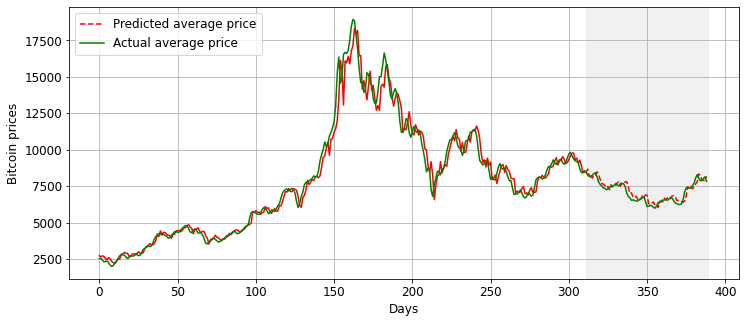

In [ ]:
# Specify the static kernel 
static_kernel = sigkernel.RBFKernel(sigma=best_sigma)

# Initialize the corresponding signature kernel
signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order=0)

# Gram matrix test
G_train = signature_kernel.compute_Gram(x_train, x_train, sym=True).numpy()
G_test = signature_kernel.compute_Gram(x_test, x_train, sym=False).numpy()

# predict
y_train_predict = best_pde_model.predict(G_train)
y_test_predict = best_pde_model.predict(G_test)  

# calculate errors
p_error_test = mean_absolute_percentage_error(np.array(y_test).reshape(-1,1), np.array(y_test_predict).reshape(-1,1))

# plot results
PlotResult(y_train, y_test, y_train_predict, y_test_predict, 'RKer - RBF')

In [ ]:
p_error_test

3.253187695721775

In [ ]:
end = time.time()
print(end - start)

209.5862934589386


# SigKer - Linear

In [41]:
from torch.nn.functional import normalize

start = time.time()

x_train_ = normalize(x_train, dim=2)
x_test_ = normalize(x_test, dim=2)

In [ ]:
# hyperparameters for grid search
svr_parameters = {'C': np.logspace(0, 4, 5), 'gamma': np.logspace(-4, 4, 9)}

In [ ]:
best_error = 1e8

# Specify the static kernel 
static_kernel = sigkernel.LinearKernel()

# Initialize the corresponding signature kernel
signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order=0)

# Gram matrix train
G_train = signature_kernel.compute_Gram(x_train_, x_train_, sym=True).numpy()

# fit the model
svr = SVR(kernel='precomputed')
svr_pde = GridSearchCV(estimator=svr, param_grid=svr_parameters, cv=5, n_jobs=-1)
svr_pde.fit(G_train, np.squeeze(y_train))
        
if np.abs(1.-svr_pde.best_score_) < np.abs(1.-best_error):
    best_pde_model = svr_pde
    best_error = svr_pde.best_score_

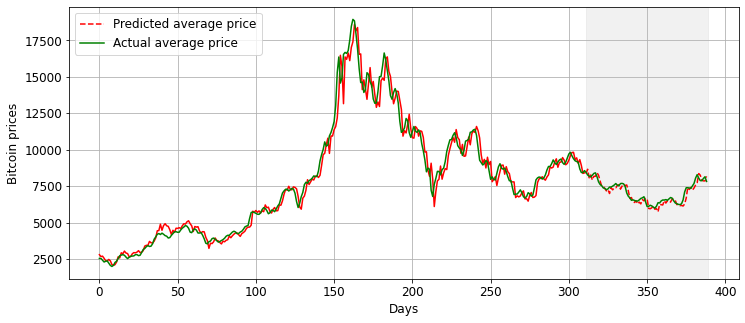

In [ ]:
# Specify the static kernel 
static_kernel = sigkernel.LinearKernel()

# Initialize the corresponding signature kernel
signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order=0)

# Gram matrix test
G_train = signature_kernel.compute_Gram(x_train_, x_train_, sym=True).numpy()
G_test = signature_kernel.compute_Gram(x_test_, x_train_, sym=False).numpy()

# predict
y_train_predict = best_pde_model.predict(G_train)
y_test_predict = best_pde_model.predict(G_test)  

# calculate errors
p_error_test = mean_absolute_percentage_error(np.array(y_test).reshape(-1,1), np.array(y_test_predict).reshape(-1,1))

# plot results
PlotResult(y_train, y_test, y_train_predict, y_test_predict, 'RKer - Linear')

In [ ]:
p_error_test

3.036557060078308

In [ ]:
end = time.time()
print(end - start)

74.58961606025696


# rSig 

In [42]:
start = time.time()

x_train_ = x_train_.detach().numpy()
x_test_ = x_test_.detach().numpy()

In [43]:
# hyperparameters for grid search
svr_parameters = {'C': np.logspace(0, 4, 5), 'gamma': np.logspace(-4, 4, 9)}

In [44]:
MC_iterations = 15
hidden_dim = 25

100%|██████████| 15/15 [00:15<00:00,  1.01s/it]

Fitting 5 folds for each of 45 candidates, totalling 225 fits


5.113245868539357
3.0938129091769166



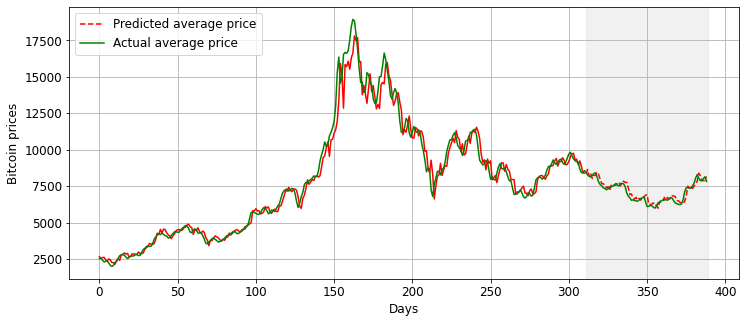

In [45]:
X = np.concatenate([x_train_,x_test_], axis = 0)

N = x_train_.shape[0]
M = x_test_.shape[0]

Gram_train = np.zeros((MC_iterations, N, N))
Gram_test = np.zeros((MC_iterations, M, N))

for m in tqdm(range(MC_iterations)):
  S = rSig_Euler(X, hidden_dim)

  sigs_train = S[:N,:]
  sigs_test = S[N:,:]

  # Make Gram Matrices
  for i in range(N):
    for j in range(N):
      Gram_train[m,i,j] = sigs_train[i].dot(sigs_train[j])

  for i in range(M):
    for j in range(N):
      Gram_test[m,i,j] = sigs_test[i].dot(sigs_train[j])

Gram_train = np.mean(Gram_train, axis=0)
Gram_test = np.mean(Gram_test, axis=0)

# fit the model
svr = SVR(kernel='precomputed')
svr_pde = GridSearchCV(estimator=svr, param_grid=svr_parameters, cv=5, n_jobs=-1, verbose = 4)
svr_pde.fit(Gram_train, np.squeeze(y_train))

# predict
y_train_predict = svr_pde.predict(Gram_train)
y_test_predict = svr_pde.predict(Gram_test)  

# calculate errors
p_error_train = mean_absolute_percentage_error(np.array(y_train).reshape(-1,1), np.array(y_train_predict).reshape(-1,1))
p_error_test = mean_absolute_percentage_error(np.array(y_test).reshape(-1,1), np.array(y_test_predict).reshape(-1,1))

print(p_error_train)
print(p_error_test)
print("")

# plot results
PlotResult(y_train, y_test, y_train_predict, y_test_predict, 'rSig')

In [46]:
end = time.time()
print(end - start)

17.448266744613647


Note how rSig Kernel is significantly faster than SigKer, 4x than Linear and 10x than RBF, while having almost the same performance!

We are counting CV for all of them.

# rSigKer - Performance Analysis 

In [ ]:
X = np.concatenate([x_train_,x_test_], axis = 0)

N = x_train_.shape[0]
M = x_test_.shape[0]

In [ ]:
def testing(hidden_dim, MC_iterations):

  start = time.time()
  Gram_train = np.zeros((MC_iterations, N, N))
  Gram_test = np.zeros((MC_iterations, M, N))

  for m in range(MC_iterations):
    S = rSig_Euler(X, hidden_dim)

    sigs_train = S[:N,:]
    sigs_test = S[N:,:]

    # Make Gram Matrices
    for i in range(N):
      for j in range(N):
        Gram_train[m,i,j] = sigs_train[i].dot(sigs_train[j])

    for i in range(M):
      for j in range(N):
        Gram_test[m,i,j] = sigs_test[i].dot(sigs_train[j])

  Gram_train = np.mean(Gram_train, axis=0)
  Gram_test = np.mean(Gram_test, axis=0)

  # fit the model
  svr = SVR(kernel='precomputed')
  svr_pde = GridSearchCV(estimator=svr, param_grid=svr_parameters, cv=5, n_jobs=-1)
  svr_pde.fit(Gram_train, np.squeeze(y_train))

  # predict
  y_train_predict = svr_pde.predict(Gram_train)
  y_test_predict = svr_pde.predict(Gram_test)  

  # calculate errors
  p_error_train = mean_absolute_percentage_error(np.array(y_train).reshape(-1,1), np.array(y_train_predict).reshape(-1,1))
  p_error_test = mean_absolute_percentage_error(np.array(y_test).reshape(-1,1), np.array(y_test_predict).reshape(-1,1))

  end = time.time()
  return [p_error_train, p_error_test, end - start]

In [ ]:
H_dims = [1,2,5,10,25,50,100,200,500]
iters = [1,2,5,10,15,20,50]

testing_results = np.zeros((len(H_dims), len(iters), 3))
for i in tqdm(range(len(H_dims))):
  for j in tqdm(range(len(iters)), leave=False):
    testing_results[i, j, :] = testing(H_dims[i], iters[j])

In [ ]:
testing_results_ = testing_results

In [ ]:
#np.savetxt('train_errors.csv', testing_results[:, :, 0], delimiter=",")
#np.savetxt('test_errors.csv', testing_results[:, :, 1], delimiter=",")
#np.savetxt('times.csv', testing_results[:, :, 2], delimiter=",")

#H_dims = [1,2,5,10,25,50,100,200,500]
#iters = [1,2,5,10,15,20,50]
#testing_results = np.zeros((len(H_dims), len(iters), 3))

#testing_results[:, :, 0] = pd.read_csv('/content/train_errors.csv', header = None).to_numpy()
#testing_results[:, :, 1] = pd.read_csv('/content/test_errors.csv', header = None).to_numpy()
#testing_results[:, :, 2] = pd.read_csv('/content/times.csv', header = None).to_numpy()


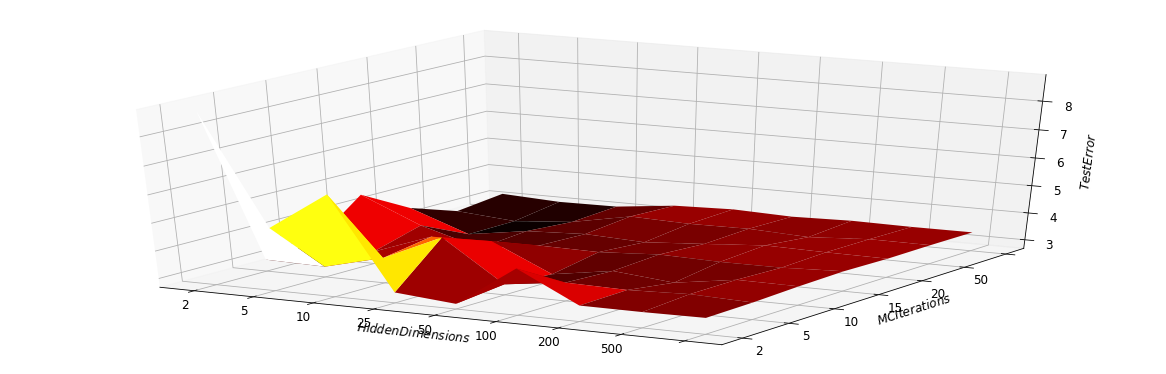

In [ ]:
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d.axes3d import Axes3D


xdata = range(len(H_dims))
ydata = range(len(iters))
zdata = testing_results[:, :, 1].T

xs, ys = np.meshgrid(xdata, ydata)

fig = plt.figure()
ax = Axes3D(fig)
ax.set_xlabel('$Hidden Dimensions$')
ax.set_xticklabels(H_dims)
ax.set_ylabel('$MC Iterations$')
ax.set_yticklabels(iters)
ax.set_zlabel('$Test Error$')
ax.plot_surface(xs, ys, zdata, rstride=1, cstride=1, cmap='hot')
plt.show()


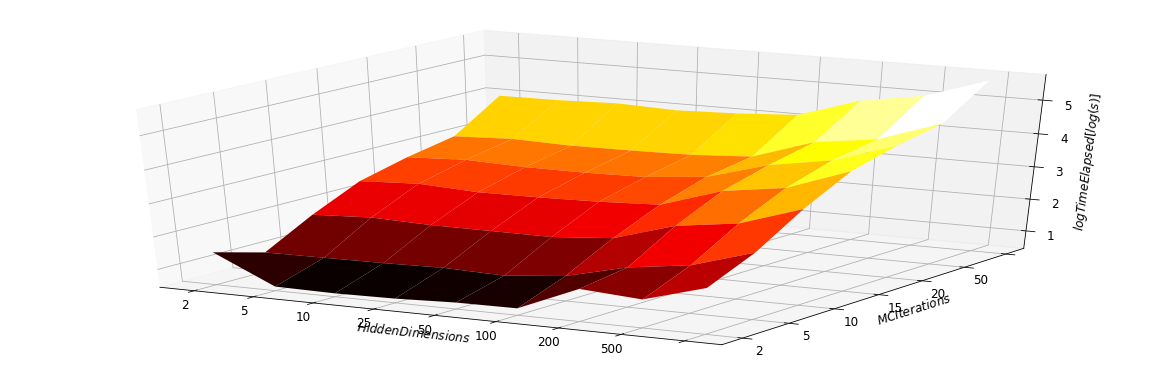

In [ ]:
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d.axes3d import Axes3D


xdata = range(len(H_dims))
ydata = range(len(iters))
zdata = np.log(testing_results[:, :, 2].T)

xs, ys = np.meshgrid(xdata, ydata)

fig = plt.figure()
ax = Axes3D(fig)
ax.set_xlabel('$Hidden Dimensions$')
ax.set_xticklabels(H_dims)
ax.set_ylabel('$MC Iterations$')
ax.set_yticklabels(iters)
ax.set_zlabel('$logTime Elapsed [log(s)]$')
ax.plot_surface(xs, ys, zdata, rstride=1, cstride=1, cmap='hot')
plt.show()

# Misc - Critique

The naive model which just outputs the average over the last two trading days outperforms every other model...

5.575206320062502
2.960274015501237



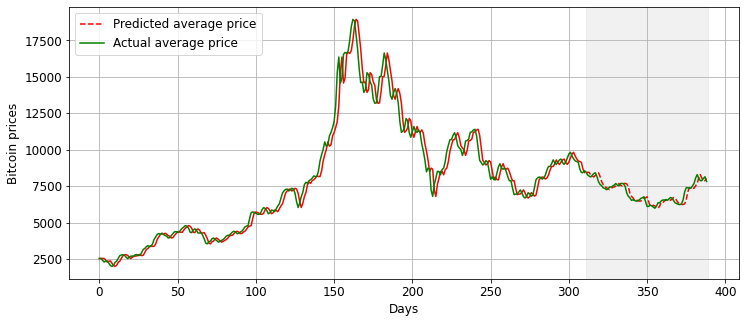

In [37]:
y_tr = y_train.to_numpy()[:,0]
y_te = y_test.to_numpy()[:,0]

y_tr_ = np.append(y_tr[0],y_tr[:-2])
y_tr_ = np.append(y_tr[0],y_tr_)

y_te_ = np.append(y_te[0],y_te[:-2])
y_te_ = np.append(y_te[0],y_te_)


p_error_train = mean_absolute_percentage_error(np.array(y_train).reshape(-1,1), np.array(y_tr_).reshape(-1,1))
p_error_test = mean_absolute_percentage_error(np.array(y_test).reshape(-1,1), np.array(y_te_).reshape(-1,1))


print(p_error_train)
print(p_error_test)
print("")

PlotResult(y_train, y_test, y_tr_, y_te_, 'rSig')

Moreover our sig models are closer to this naive than to the actual solution!

In [47]:
p_error_train = mean_absolute_percentage_error(np.array(y_train_predict).reshape(-1,1), np.array(y_tr_).reshape(-1,1))
p_error_test = mean_absolute_percentage_error(np.array(y_test_predict).reshape(-1,1), np.array(y_te_).reshape(-1,1))

print(p_error_train)
print(p_error_test)
print("")

3.1054179988376043
1.6650341830060194

